In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
%matplotlib widget

# Modelled system

The modelled system is a 2D wave equation with damping and an external force term

$\begin{align*}
\frac{\partial^2 u}{\partial t^2} +\alpha \frac{\partial u}{\partial t} - c^2(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) = B
\end{align*}$

where $\alpha \frac{\partial u}{\partial t}$ is the damping term and $B$ is the external force term. $c$ is the speed that the wave propagates in the medium. We will solve this PDE using what we learned in [Notebook 2 (2nd order ODE)](./02_2nd_order_ode.ipynb) and [Notebook 3 (2D diffusion equation)](./03_2D_diff_equation_MOL.ipynb). Furthermore, we will use the same domain as in the Notebook 3 which is 

\begin{align*}
t &\in [0, 100] \\
\{x,y\} &\in [0, 10]
\end{align*}

and with the source term

\begin{align*}
B &= 1 \: (1 < t < 4) \: (2.5 \leq x \leq 3.5) \: (1.5 \leq y \leq 4.5) \\
B &= 0 \ (\mathrm{otherwise})
\end{align*}

and constants

\begin{align*}
c &= 0.5 \\
\alpha &= 0.1
\end{align*}

subject to Dirichlet boundary conditions

\begin{equation*}
    u_{\mathrm{boundary}} = 0
\end{equation*}

## First let's define the spatial solution doman

In [104]:
# Grid resolution and max length
dx = 0.25
dy = 0.25
lx = 10
ly = 10

# Number of gridpoints
Nx = int(lx/dx) + 1
Ny = int(ly/dy) + 1

# grid point vectors
x = np.linspace(0,lx,Nx)
y = np.linspace(0,ly,Ny)

## Then let's transform the 2nd order PDE into a system of ODEs

In [Notebook 2 (2nd order ODE)](./02_2nd_order_ode.ipynb) we solved a 2nd order ODE. Our initial ODE was just one equation but after transformation we had 2 equations. In [Notebook 3 (2D diffusion equation)](./03_2D_diff_equation_MOL.ipynb) we transformed a 1st order PDE into a system of ODEs. In that case the original PDE was transformed into $N_x \cdot N_y$ ODEs where $N_x$ and $N_y$ where the number of discretized spatial domain points in x and y directions, respectively. 

Next we will do both transformation to our 2nd order PDE: we will modify it to set of first order ODEs in time and space which will yield $2(N_x \cdot N_y)$ ODEs

First let's transform the 2nd order PDE into a system of 1st order PDEs. Our initial 2nd order PDE looks like this

\begin{align*}
\frac{\partial^2 u}{\partial t^2} +\alpha \frac{\partial u}{\partial t} - c^2(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) = B
\end{align*}

Now define 
\begin{align*}
y_1 &= u \\
y_2 &= \frac{\partial u}{\partial t}
\end{align*}

which will yield

\begin{align*}
\frac{\partial y_1}{\partial t} &= y_2 \\
\frac{\partial y_2}{\partial t} &= -\alpha y_2 + c^2(\frac{\partial^2 y_1}{\partial x^2} + \frac{\partial^2 y_1}{\partial y^2}) + B \\
\end{align*}

Then let's discretize the PDE in the spatial domain using the finite difference method from [Notebook 3 (2D diffusion equation)](./03_2D_diff_equation_MOL.ipynb)

\begin{align*}
\frac{\mathrm{d} y_1^{i,j}}{\mathrm{d} t} &= y_2^{i,j} \\
\frac{\mathrm{d} y_2^{i,j}}{\mathrm{d} t} &= -\alpha y_2 + c^2\left(  \frac{y_1^{i+1,j} - 2 y_1^{i, j} + y_1^{i-1, j}}{(\Delta x)^2} +\frac{y_1^{i,j+1} - 2y_1^{i, j} + y_1^{i,j-1}}{(\Delta y)^2} \right) + B
\end{align*}

where the supscript (i,j) refers to ith x element and jth y element and i goes from $0 \to N_x$ and j goes from $0 \to N_y$



## Next define the external force function to calculate B

In [107]:
def external_force(x, y, t, B, Nx, Ny):
    u = np.zeros((Nx, Ny))
    if t < 4.0 and t > 1:
        ind_x = np.where((x>= 2.5) & (x<=3.5))[0]
        ind_y = np.where((y>=1.5) & (y<=4.5))[0]
        for ix in ind_x:
            for iy in ind_y:
                u[ix,iy] = B
    return u

## Define the right hand side of the ODE system

In [106]:
def odefun(u, t, B, a, c, x, y, dx, dy, Nx, Ny):
    y1 = u[:Nx*Ny].reshape(Nx,Ny)
    y2 = u[Nx*Ny:].reshape(Nx,Ny)
    dy1dt = y2

    f_ext = external_force(x, y, t, B, Nx, Ny)

    dy2dt = np.zeros((Nx, Ny))

    # First calculate only the c^2(u_xx + u_yy) term for dy2dt
    dy2dt[1:-1, 1:-1] = c**2*((y1[2:, 1:-1] - 2*y1[1:-1, 1:-1] + y1[:-2,1:-1] ) / (dx)**2 + (y1[1:-1, 2:] - 2*y1[1:-1, 1:-1] + y1[1:-1,:-2]) / (dy)**2)
    
    # Then add the other terms to dy2dt
    dy2dt = dy2dt - a*y2 + f_ext

    dy1dt = dy1dt.reshape(Nx*Ny,)
    dy2dt = dy2dt.reshape(Nx*Ny,)

    return np.concatenate((dy1dt, dy2dt))

## Define constants

In [91]:
a = 0.1
B = 1
c = 0.5

## Solve the system

In [111]:
u_start = np.zeros((2*Nx*Ny,))
sol = solve_ivp(lambda t,u: odefun(u,t,B,a,c,x,y,dx,dy,Nx,Ny), (0, 100),u_start, t_eval=np.linspace(0,100, 101))
print(sol.y.shape)

(3362, 101)


## Visualize solution

interactive(children=(IntSlider(value=0, description='Time'), Output()), _dom_classes=('widget-interact',))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
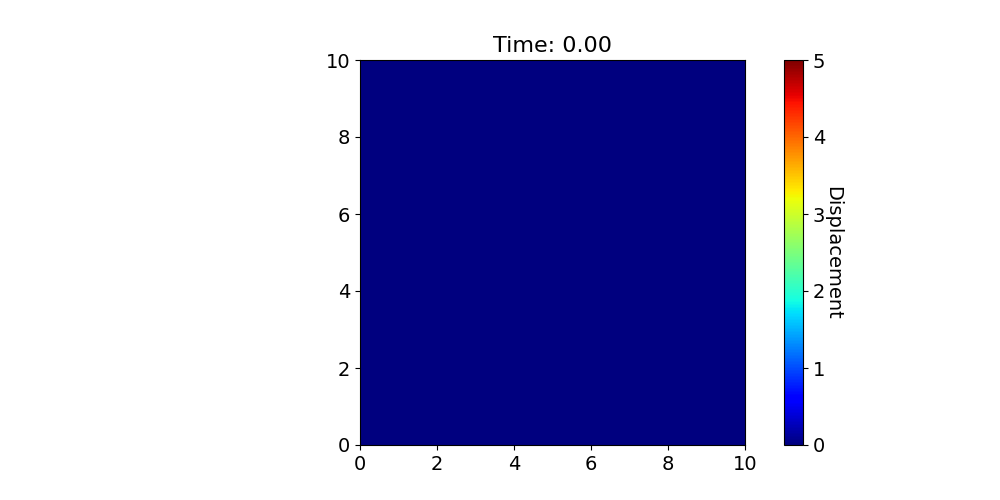

In [112]:
fig, ax = plt.subplots(figsize=(10, 5))
img2 = ax.imshow(np.random.uniform(size=(10,10)), cmap='jet', vmin=0, vmax=5)
cbar = fig.colorbar(img2)
cbar.ax.set_ylabel('Displacement', rotation=270, labelpad=12, fontsize=14)
cbar.ax.tick_params(axis='y', labelsize=14)

def plot_solution(Time):
    ax.clear()
    ax.imshow(sol.y[:Nx*Ny, Time].reshape(Nx, Ny), interpolation='nearest',
                    cmap='jet', origin='lower', extent=[0, lx, 0, ly], vmin=0, vmax=5)
    ax.set_title(f'Time: {sol.t[Time]:.2f}', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    # cbar.ax.yaxis.set_ticks_position('left')


widgets.interactive(plot_solution, Time=widgets.IntSlider(min=0, max=(len(sol.t)-1), value=0))